***Importing Packages***

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.layers import Dense,TimeDistributed,LSTM,Dropout,Bidirectional,RNN,SimpleRNN
from keras.activations import sigmoid,relu
from keras import Sequential

## The Code Consists of Two Model (LSTM + Prophet) and output result is a average both prediction 

In [2]:
train_dataframe = pd.read_csv(r"train.csv")

In [3]:
train_dataframe.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


### **Preprocessing Steps**

**Inspecting the data to identify missing_values and seperating datatime into seperate_columns there are 1900 missing values in the dataframe filling all the missing values using ffill(forward fill)**

In [4]:
train_dataframe.isnull().sum()

row_id         0
datetime       0
energy      1900
dtype: int64

In [5]:
train_dataframe.describe()

,row_id,energy
count,94992.000000,93092.000000
mean,47496.500000,1702.995014
std,27421.972723,369.322103
min,1.000000,866.388600
25%,23748.750000,1431.541100
50%,47496.500000,1654.465800
75%,71244.250000,1935.993450
max,94992.000000,3374.399600


In [6]:
train_dataframe.drop(["row_id"],axis =1,inplace=True)

In [7]:
train_dataframe.fillna(method ="ffill",inplace=True)

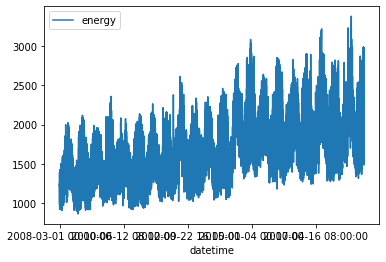

In [8]:
train_dataframe.plot(x="datetime",y = "energy")

**Data partition for model 1**

In [9]:
df_model_lstm = train_dataframe.copy(deep=False)

In [10]:
def preprocessing(input_dataframe):
  input_dataframe['datetime'] = pd.to_datetime(input_dataframe['datetime'])
  input_dataframe['day'] = input_dataframe['datetime'].dt.day
  input_dataframe['month'] = input_dataframe['datetime'].dt.month
  input_dataframe['year'] = input_dataframe['datetime'].dt.year
  input_dataframe['Time'] = input_dataframe['datetime'].dt.time
  df_hrs = input_dataframe['Time'].astype(str).str.split(':', expand=True).astype(float)
  input_dataframe["hours"] = df_hrs[0]
  input_dataframe = input_dataframe.drop(["datetime","Time"],axis=1)
  return(input_dataframe)

In [11]:
df_model_lstm = preprocessing(df_model_lstm)

In [12]:
df_model_lstm.head()

,energy,day,month,year,hours
0,1259.985563,1,3,2008,0.0
1,1095.541500,1,3,2008,1.0
2,1056.247500,1,3,2008,2.0
3,1034.742000,1,3,2008,3.0
4,1026.334500,1,3,2008,4.0


Scaling the input and ouptut value in range(0,1) for model to predict better

In [13]:
output_scaler = MinMaxScaler()
df_model_lstm['energy']=output_scaler.fit_transform(df_model_lstm['energy'].values.reshape(-1,1))

In [14]:
output = df_model_lstm["energy"]
df_model_lstm.drop(["energy"],axis=1,inplace=True)

In [15]:
scaler =MinMaxScaler()
scaler.fit(df_model_lstm)
df_model_lstm =scaler.transform(df_model_lstm)

In [16]:
df_model_lstm

array([[0.        , 0.18181818, 0.        , 0.        ],
       [0.        , 0.18181818, 0.        , 0.04347826],
       [0.        , 0.18181818, 0.        , 0.08695652],
       ...,
       [1.        , 1.        , 1.        , 0.91304348],
       [1.        , 1.        , 1.        , 0.95652174],
       [1.        , 1.        , 1.        , 1.        ]])

# Train test split on training data to reduce overfitting as well identify accuracy on unseen data

In [17]:
train_x,val_x,train_y,val_y = train_test_split(df_model_lstm,output,test_size=0.01)

**Creating single layer LSTM model**

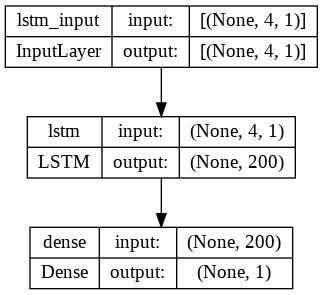

In [18]:
model = Sequential()
model.add(LSTM(200, input_shape = (train_x.shape[1],1), activation='relu'))
model.add(Dense(1))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [19]:
model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(train_x, train_y,validation_data=(val_x,val_y), epochs=20, batch_size=32,callbacks=[callback])

Epoch 1/20
2939/2939 [==============================] - 51s 16ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0788 - val_loss: 0.0065 - val_mse: 0.0065 - val_mae: 0.0634
Epoch 2/20
2939/2939 [==============================] - 37s 13ms/step - loss: 0.0057 - mse: 0.0057 - mae: 0.0582 - val_loss: 0.0056 - val_mse: 0.0056 - val_mae: 0.0585
Epoch 3/20
2939/2939 [==============================] - 37s 12ms/step - loss: 0.0052 - mse: 0.0052 - mae: 0.0556 - val_loss: 0.0051 - val_mse: 0.0051 - val_mae: 0.0553
Epoch 4/20
2939/2939 [==============================] - 37s 13ms/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0542 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0530
Epoch 5/20
2939/2939 [==============================] - 36s 12ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0531 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae: 0.0533
Epoch 6/20
2939/2939 [==============================] - 38s 13ms/step - loss: 0.0046 - mse: 0.0046 - mae: 0.0524 - val_loss: 0.0047 - val_mse: 0.0047 - val_mae:

In [20]:
df_test = pd.read_csv("test.csv")
df_test_new = df_test.drop('row_id',axis=1)
#preprocessing_of_data
df_test_new = preprocessing(df_test_new)
df_test_min = scaler.transform(df_test_new)
output_result = model.predict(df_test_min)
df_test["energy_lstm"] = output_scaler.inverse_transform(output_result)
#df_test.drop('datetime',axis=1,inplace=True)

822/822 [==============================] - 4s 5ms/step


In [21]:
df_test.head()

,row_id,datetime,energy_lstm
0,94993,2019-01-01 00:00:00,1727.141968
1,94994,2019-01-01 01:00:00,1606.531128
2,94995,2019-01-01 02:00:00,1505.250488
3,94996,2019-01-01 03:00:00,1439.143677
4,94997,2019-01-01 04:00:00,1416.070435


### **Model_2 Fp Prophet**

In [22]:
df_model_prophet = train_dataframe.copy(deep=False)

In [23]:
df_model_prophet.head()

,datetime,energy
0,2008-03-01 00:00:00,1259.985563
1,2008-03-01 01:00:00,1095.541500
2,2008-03-01 02:00:00,1056.247500
3,2008-03-01 03:00:00,1034.742000
4,2008-03-01 04:00:00,1026.334500


In [24]:
df_model_prophet['datetime'] = pd.to_datetime(df_model_prophet['datetime'])
df_model_prophet.set_index('datetime', inplace=True)
df_model_prophet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  94992 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


In [25]:
df_model_prophet.head()

,energy
datetime,
2008-03-01 00:00:00,1259.985563
2008-03-01 01:00:00,1095.541500
2008-03-01 02:00:00,1056.247500
2008-03-01 03:00:00,1034.742000
2008-03-01 04:00:00,1026.334500


Renaming column values 

In [26]:
model_prophet = Prophet()
model_prophet.fit(df_model_prophet.reset_index() \
              .rename(columns={'datetime':'ds',
                               'energy':'y'}))

In [27]:
prophet_test = df_test.copy(deep=False) 

In [28]:
prophet_test = prophet_test.drop(["row_id","energy_lstm"],axis=1)

In [29]:
prophet_test.head()

,datetime
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00
2,2019-01-01 02:00:00
3,2019-01-01 03:00:00
4,2019-01-01 04:00:00


In [30]:
#prophet_test['datetime'] = pd.to_datetime(prophet_test['datetime'])
#prophet_test.set_index('datetime', inplace=True)
prophet_test_result = model_prophet.predict(df=prophet_test.reset_index() \
                                   .rename(columns={'datetime':'ds'}))

In [31]:
df_test["energy_prophet"] = prophet_test_result["yhat"]

In [32]:
df_test.head()

,row_id,datetime,energy_lstm,energy_prophet
0,94993,2019-01-01 00:00:00,1727.141968,2023.639536
1,94994,2019-01-01 01:00:00,1606.531128,1948.104928
2,94995,2019-01-01 02:00:00,1505.250488,1892.600754
3,94996,2019-01-01 03:00:00,1439.143677,1863.924389
4,94997,2019-01-01 04:00:00,1416.070435,1867.323906


In [33]:
df_test['energy'] = df_test[['energy_lstm', 'energy_prophet']].mean(axis=1)

In [34]:
df_submission = df_test.drop(['energy_lstm','energy_prophet','datetime'],axis=1)

In [35]:
df_submission.head()

,row_id,energy
0,94993,1875.390752
1,94994,1777.318028
2,94995,1698.925621
3,94996,1651.534033
4,94997,1641.697170


In [36]:
df_submission.to_csv("submission.csv",index=False)